In [1]:
import sys
sys.path.append('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/')

In [2]:
import os 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Hyperparam_Testing.Testing_Notebooks.Common_Functions as cf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 

from keras.regularizers import l2
from Hyperparam_Testing.Testing_Notebooks import chirallag as cL

import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'font.size': 16})

In [3]:
## Generate fields 
data = cf.gen_and_load(10**5,10**3)

In [4]:
#Hold out Validation
train_x, train_y = data[0]
val_x,val_y = data[1] 

In [5]:
noise_std = np.logspace(-4,-1,5)
noisy_xs_train = []
noisy_xs_val = []
for i in noise_std:
    noisy_xs_train.append(cf.apply_noise(train_x,i))
    noisy_xs_val.append(cf.apply_noise(train_x,i))

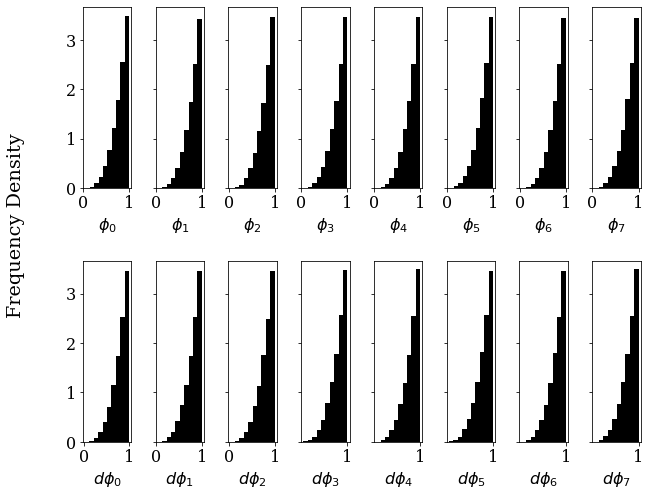

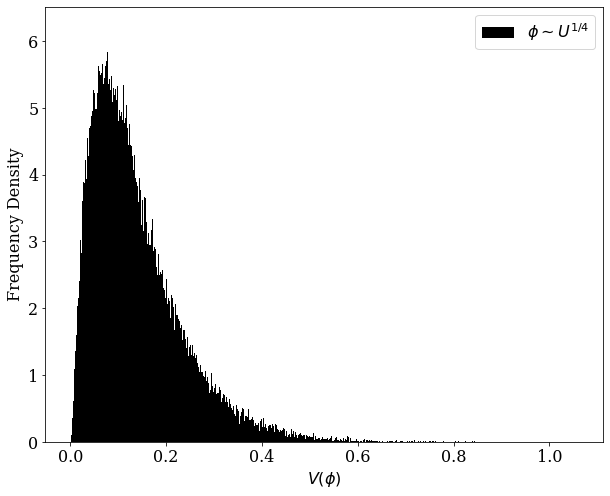

In [6]:
#Sense check fields
cf.field_plotter(noisy_xs_train[0],train_y)

In [7]:
opt = keras.optimizers.Adam(amsgrad= True, beta_1= 0.9, beta_2=0.98)

In [8]:
def noise_test(noise_std,repeats):
    no_noise_std = len(noise_std)
    is_last_val_bool = np.zeros(no_noise_std)
    min_mape = np.zeros((no_noise_std,repeats))
    ii = 0
    fig ,ax = plt.subplots(1)
    for ii,i in enumerate(noise_std):   
        print('noise with sigma = ',i)
        last_val_bool = 0
        for j in range(repeats):
            
            ### Training 
            x_train = cf.apply_noise(train_x,i)
            x_val = cf.apply_noise(val_x,i)
            df = pd.DataFrame(cf.trained_network(x_train,train_y,x_val,val_y,np.ones(5)*300, optimizer= opt , verbose= 0,epochs = 100, batch_size= 32,initializer= 'random_normal').history)
            val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.4)
            loss_ar_smoothed = cf.exponetial_smoothing(np.array(df['loss']),0.4)
            min_mape[ii,j] = np.min(val_mape_ar_smoothed)
            
            
            



            ### Negative Grad
            if cf.neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                last_val_bool +=1
                print('Negative Grad Identified')
            else:
                pass
        if last_val_bool >= repeats/4:
            is_last_val_bool[ii] = 1
        else:
            is_last_val_bool[ii] = 0
        ###Plotting each training cycle
        epoch_num = len(df['val_mean_absolute_percentage_error'])
        epochs = np.arange(1,epoch_num+1)
        ax.plot(epochs,loss_ar_smoothed, color = 'black',label = 'Smoothed  MAPE ')
        ax.plot(epochs,val_mape_ar_smoothed, color = 'red',label = 'Smoothed Validation MAPE')
        ax.set_xlabel('Training Epochs')
        ax.set_ylabel('Mean Minimum MAPE')
        ax.set_ylim(0,20)
        ax.set_title('$\sigma ={{{}}}$'.format(i))
        plt.show()
    path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Guassian_Noise/Training_Data'
    file_name = 'Guassian_noise'+str(noise_std[0])+'-'+str(noise_std[-1]) 
    np.savetxt(os.path.join(path,file_name+'mape.csv'),min_mape,delimiter=',')
    np.savetxt(os.path.join(path,file_name+'bool.csv'),is_last_val_bool,delimiter=',')
    return min_mape, is_last_val_bool

noise with sigma =  0.0001


2022-02-08 13:26:02.060446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:26:02.066504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:26:02.066829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:26:02.067673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

InternalError:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node sequential_1/dense_6/MatMul (defined at home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Hyperparam_Testing/Testing_Notebooks/Common_Functions.py:62) ]] [Op:__inference_train_function_1212]

Function call stack:
train_function


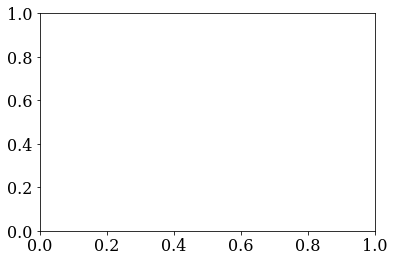

In [9]:
min_mape ,bool = noise_test(noise_std, 10)